In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import networkx as nx
import uproot
from collections import deque

In [2]:
!cd tools/ && python setup_opera_distance_metric.py build_ext --inplace
from tools.opera_distance_metric import generate_k_nearest_graph, opera_distance_metric_py, generate_radius_graph


import torch
#import torch_scatter
import torch_geometric
from torch_geometric.data import Data
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

running build_ext


In [3]:
def pmc_to_ship_format(showers_df, num_showers_in_brick):
    gb = showers_df.groupby('signal')
    showers = [gb.get_group(x) for x in gb.groups]
    showers_with_brick_id = []
    for i, shower in enumerate(showers):
        shower = shower.copy(deep=True)
        shower['brick_id'] = i // num_showers_in_brick
        showers_with_brick_id.append(shower)
    return showers_with_brick_id

In [4]:
from collections import defaultdict
from joblib import Parallel, delayed

def gen_one_shower(df_brick, knn=False, r=250, k=5, symmetric=False, directed=False, e=0.00005, scale=1e4):
    print('Start!')
    from tools.opera_distance_metric import generate_k_nearest_graph, opera_distance_metric_py, generate_radius_graph
    if knn:
        edges_from, edge_to, dist = generate_k_nearest_graph(
            df_brick[["brick_id", "SX", "SY", "SZ", "TX", "TY"]].values,
            k,
            e=e,
            symmetric=symmetric, directed=directed)
        edges = np.vstack([edges_from, edge_to])
        dist = np.array(dist)
        edge_index = torch.LongTensor(edges)
    else:
        edges_from, edge_to, dist = generate_radius_graph(
            df_brick[["brick_id", "SX", "SY", "SZ", "TX", "TY"]].values,
            r,
            e=e,
            symmetric=symmetric, directed=directed)
        edges = np.vstack([edges_from, edge_to])
        dist = np.array(dist)
        edge_index = torch.LongTensor(edges)

    x = torch.FloatTensor(df_brick[["SX", "SY", "SZ", "TX", "TY"]].values / np.array([scale, scale, scale, 1., 1.]))
    shower_data = torch.FloatTensor(
        df_brick[["ele_P", "ele_SX", "ele_SY", "ele_SZ", "ele_TX", "ele_TY", "numtracks", "signal"]].values / np.array(
            [1., scale, scale, scale, 1., 1., 1., 1.]))
    edge_attr = torch.log(torch.FloatTensor(dist).view(-1, 1))
    y = torch.LongTensor(df_brick.signal.values)
    shower = torch_geometric.data.Data(
        x=x,
        edge_index=edge_index,
        shower_data=shower_data,
        pos=x,
        edge_attr=edge_attr,
        y=y
    )
    return shower


def gen_torch_showers(df, knn=False, r=250, k=5, symmetric=False, directed=False, e=0.00005, scale=1e4):
    df_bricks = [df[df.brick_id == brick_id] for brick_id in list(df.brick_id.unique())][:5]
    showers = Parallel(n_jobs=5)(
        delayed(gen_one_shower)(df_brick, knn=knn, r=r, k=k, symmetric=symmetric, directed=directed, e=e, scale=scale) for df_brick in
        df_bricks)
    return showers

In [5]:
%%time
showers = pd.read_csv("../../em_showers_generation/showers_18k_final_ver1.csv")

CPU times: user 5.03 s, sys: 666 ms, total: 5.69 s
Wall time: 5.69 s


In [6]:
%%time
num_showers_in_brick = 200
showers = pmc_to_ship_format(showers, num_showers_in_brick)
df = pd.concat(showers)

CPU times: user 19.7 s, sys: 1.12 s, total: 20.8 s
Wall time: 20.8 s


In [7]:
%%time
showers_train_1 = gen_torch_showers(df=df, knn=True, k=1, directed=False, e=10)

CPU times: user 568 ms, sys: 379 ms, total: 947 ms
Wall time: 4min 42s


In [8]:
%%time
showers_train_2 = gen_torch_showers(df=df, knn=True, k=2, directed=False, e=10)

CPU times: user 542 ms, sys: 152 ms, total: 694 ms
Wall time: 4min 37s


In [9]:
%%time
showers_train_3 = gen_torch_showers(df=df, knn=True, k=3, directed=False, e=10)

CPU times: user 472 ms, sys: 224 ms, total: 696 ms
Wall time: 4min 35s


In [10]:
%%time
showers_train_4 = gen_torch_showers(df=df, knn=True, k=4, directed=False, e=10)

CPU times: user 482 ms, sys: 218 ms, total: 700 ms
Wall time: 4min 53s


In [11]:
%%time
showers_train_5 = gen_torch_showers(df=df, knn=True, k=5, directed=False, e=10)

CPU times: user 553 ms, sys: 228 ms, total: 780 ms
Wall time: 4min 47s


In [12]:
%%time
showers_train_6 = gen_torch_showers(df=df, knn=True, k=6, directed=False, e=10)

CPU times: user 550 ms, sys: 199 ms, total: 749 ms
Wall time: 4min 53s


In [13]:
%%time
showers_train_7 = gen_torch_showers(df=df, knn=True, k=7, directed=False, e=10)

CPU times: user 542 ms, sys: 220 ms, total: 762 ms
Wall time: 4min 57s


In [14]:
%%time
showers_train_8 = gen_torch_showers(df=df, knn=True, k=8, directed=False, e=10)

CPU times: user 549 ms, sys: 213 ms, total: 762 ms
Wall time: 4min 44s


In [15]:
%%time
showers_train_9 = gen_torch_showers(df=df, knn=True, k=9, directed=False, e=10)

CPU times: user 532 ms, sys: 225 ms, total: 757 ms
Wall time: 4min 39s


In [16]:
%%time
showers_train_10 = gen_torch_showers(df=df, knn=True, k=10, directed=False, e=10)

CPU times: user 543 ms, sys: 225 ms, total: 768 ms
Wall time: 4min 44s


In [17]:
%time
showers_train_11 = gen_torch_showers(df=df, knn=True, k=11, directed=False, e=10)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


In [18]:
%time
showers_train_12 = gen_torch_showers(df=df, knn=True, k=12, directed=False, e=10)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


In [19]:
%time
showers_train_13 = gen_torch_showers(df=df, knn=True, k=13, directed=False, e=10)

CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 5.48 µs


In [20]:
%%time
showers_train_14 = gen_torch_showers(df=df, knn=True, k=14, directed=False, e=10)

CPU times: user 568 ms, sys: 271 ms, total: 840 ms
Wall time: 4min 38s


In [21]:
%%time
showers_train_15 = gen_torch_showers(df=df, knn=True, k=15, directed=False, e=10)

CPU times: user 539 ms, sys: 306 ms, total: 845 ms
Wall time: 4min 39s


In [22]:
%%time
showers_train_16 = gen_torch_showers(df=df, knn=True, k=16, directed=False, e=10)

CPU times: user 551 ms, sys: 337 ms, total: 888 ms
Wall time: 4min 42s


In [23]:
all_train = [
    showers_train_1, showers_train_2, showers_train_3, showers_train_4, 
    showers_train_5, showers_train_6, showers_train_7, showers_train_8, 
    showers_train_9, showers_train_10, showers_train_11, showers_train_12, 
    showers_train_13, showers_train_14, showers_train_15, showers_train_16
]

In [24]:
import networkx as nx
from tqdm import tqdm

def calc_connected_components(showers):
    stats = []
    for shower in tqdm(showers):
        y = (shower.y[shower.edge_index[0]] == shower.y[shower.edge_index[1]]).numpy()
        for idx in range(shower.y.min(), shower.y.max()):
            shower_nodes = (shower.y == idx).numpy()
            edge_index = shower.edge_index[:, y].numpy()
            shower_nodes = np.where(shower_nodes)[0]
            mask_edges = np.isin(edge_index, shower_nodes).all(axis=0)
            edge_index_shower = edge_index[:, mask_edges]
            G = nx.Graph()
            G.add_edges_from(edge_index_shower.T)
            sizes = [len(d) for d in nx.connected_components(G)]
            try:
                sizes = np.array(sizes)
                num_tracks = (shower.y == idx).sum().item()
                stats.append((sizes, num_tracks))
                # stats.append((sizes[0] / np.sum(sizes), (sizes > 5).sum(), ))
            except:
                pass
        
    return stats

In [25]:
stats_connected_components = [calc_connected_components(showers_train) for showers_train in all_train]

100%|██████████| 5/5 [01:25<00:00, 17.16s/it]


In [26]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(context='paper', style="whitegrid", font_scale=3., font = 'serif')
x = np.arange(16) + 1

In [27]:
def bootstrap(tmp, q, B=100):
    X = np.random.choice(tmp, replace=True, size=(len(tmp), B))
    mean = np.percentile(tmp, q=q, axis=0)
    low, high = np.percentile(np.percentile(X, q=q, axis=0), q=[2.5, 97.5])
    return mean, low, high

In [28]:
color = 'cornflowerblue'
color_back = 'royalblue'
q = 20

In [29]:
def calc_ratio_biggest_to_sum(stats):
    arr = []
    for stat in stats:
        stat_arr, num_tracks = stat[0], stat[1]
        arr.append(stat_arr[0] / np.sum(stat_arr))
    return np.array(arr)

100%|██████████| 16/16 [00:00<00:00, 62.29it/s]


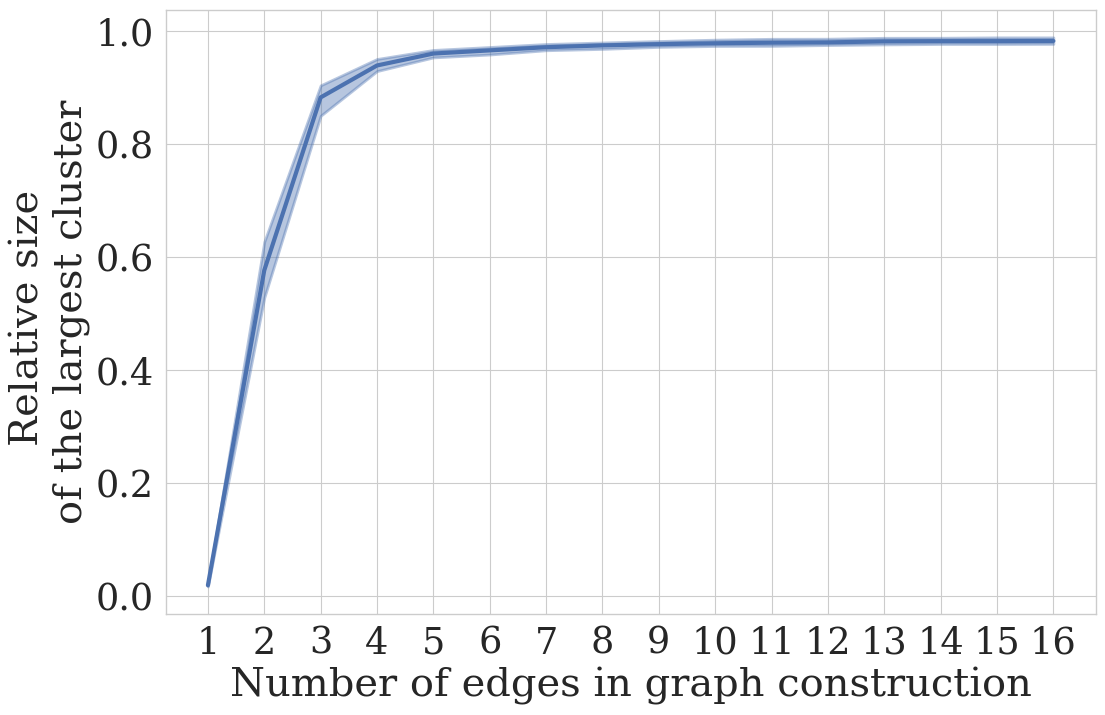

In [30]:
plt.figure(figsize=(12, 8), dpi=100)

d = []
d_low = []
d_high = []

for stat_connected_components in tqdm(stats_connected_components):
    tmp = calc_ratio_biggest_to_sum(stat_connected_components)
    mean, low, high = bootstrap(tmp, q=q, B=500)
    d.append(mean)
    d_low.append(low)
    d_high.append(high)

d = np.array(d)
d_low = np.array(d_low)
d_high = np.array(d_high)
plt.plot(x.astype(int), d, linewidth=3, c="b")
plt.fill_between(x.astype(int), d_low, d_high, color="b", alpha=0.4,  linewidth=2)
plt.xlabel("Number of edges in graph construction")
plt.ylabel("Relative size \nof the largest cluster")
plt.xticks(x.astype(int))

plt.savefig("shower_edge_vs_largest_component.pdf", bbox_inches='tight')
plt.show()

In [31]:
def calc_ratio_biggest_to_tot(stats):
    arr = []
    for stat in stats:
        stat_arr, num_tracks = stat[0], stat[1]
        arr.append(stat_arr[0] / num_tracks)
    return np.array(arr)

100%|██████████| 16/16 [00:00<00:00, 81.67it/s]


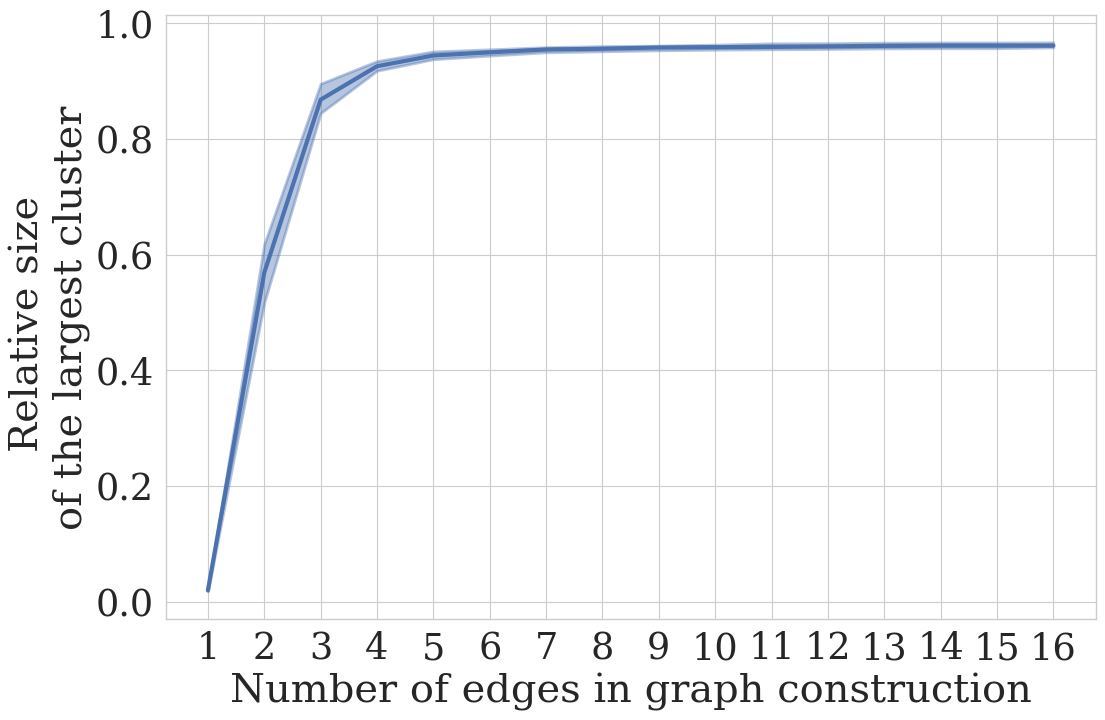

In [32]:
plt.figure(figsize=(12, 8), dpi=100)

d = []
d_low = []
d_high = []

for stat_connected_components in tqdm(stats_connected_components):
    tmp = calc_ratio_biggest_to_tot(stat_connected_components)
    mean, low, high = bootstrap(tmp, q=q, B=500)
    d.append(mean)
    d_low.append(low)
    d_high.append(high)

d = np.array(d)
d_low = np.array(d_low)
d_high = np.array(d_high)
plt.plot(x.astype(int), d, linewidth=3, c="b")
plt.fill_between(x.astype(int), d_low, d_high, color="b", alpha=0.4,  linewidth=2)
plt.xlabel("Number of edges in graph construction")
plt.ylabel("Relative size \nof the largest cluster")
plt.xticks(x.astype(int))

plt.savefig("shower_edge_vs_total.pdf", bbox_inches='tight')
plt.show()

In [33]:
def calc_num_components(stats):
    arr = []
    for stat in stats:
        stat_arr, num_tracks = stat[0], stat[1]
        arr.append(
            (stat_arr > 1).sum()
        )
        
    return np.array(arr)

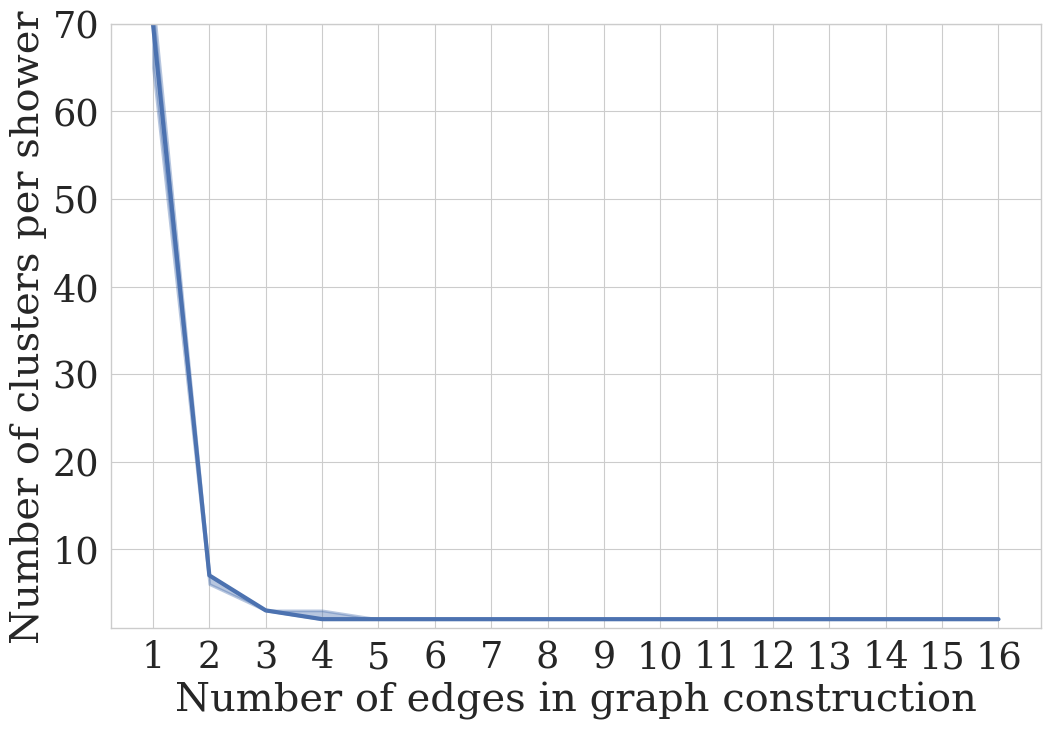

In [34]:
plt.figure(figsize=(12, 8), dpi=100)

d = []
d_low = []
d_high = []

for stat_connected_components in stats_connected_components:
    tmp = calc_num_components(stat_connected_components)
    mean, low, high = bootstrap(tmp, q=100 - q, B=1000)
    d.append(mean)
    d_low.append(low)
    d_high.append(high)

d = np.array(d)
d_low = np.array(d_low)
d_high = np.array(d_high)

plt.plot(x.astype(int), d, linewidth=3)
plt.fill_between(x.astype(int), d_low, d_high, color="b", alpha=0.4,  linewidth=2)
plt.ylim(1, d.max())
plt.xticks(x.astype(int))
# plt.yscale('log')
plt.xlabel("Number of edges in graph construction")
plt.ylabel("Number of clusters per shower")

plt.savefig("shower_edge_vs_connected_components.pdf", bbox_inches='tight')
plt.show()

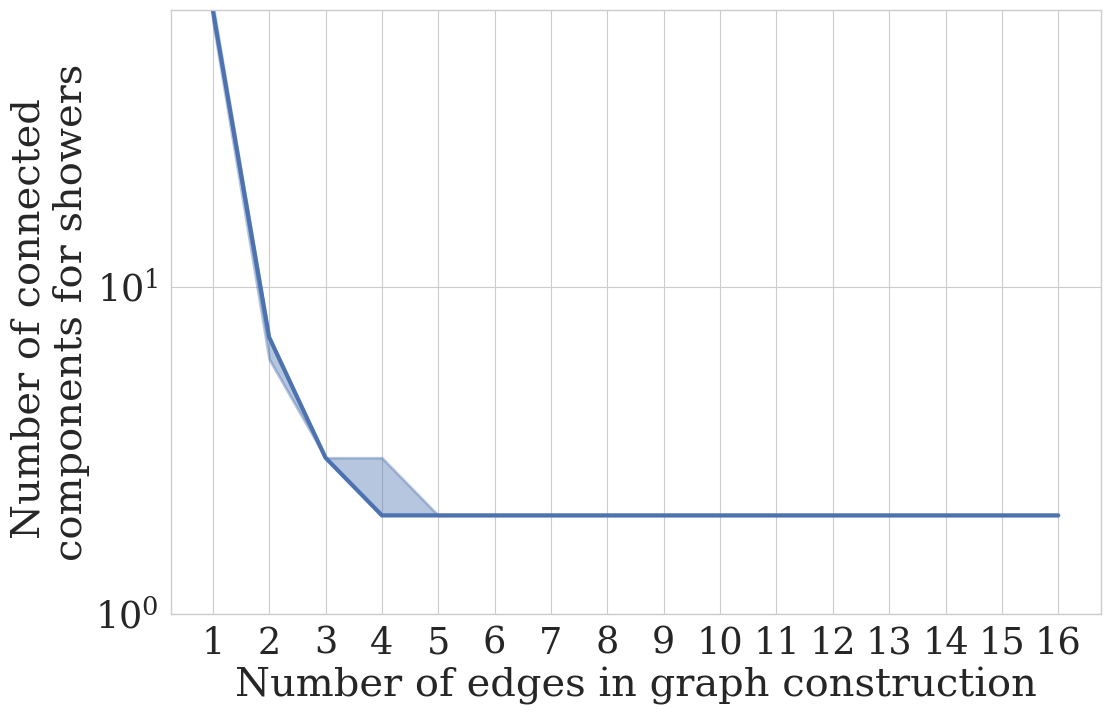

In [35]:
plt.figure(figsize=(12, 8), dpi=100)

d = []
d_low = []
d_high = []

for stat_connected_components in stats_connected_components:
    tmp = calc_num_components(stat_connected_components)
    mean, low, high = bootstrap(tmp, q=100 - q, B=1000)
    d.append(mean)
    d_low.append(low)
    d_high.append(high)

d = np.array(d)
d_low = np.array(d_low)
d_high = np.array(d_high)

plt.plot(x.astype(int), d, linewidth=3)
plt.fill_between(x.astype(int), d_low, d_high, color="b", alpha=0.4,  linewidth=2)
plt.ylim(1, d.max())
plt.xticks(x.astype(int))
plt.yscale('log')
plt.xlabel("Number of edges in graph construction")
plt.ylabel("Number of connected \ncomponents for showers")

plt.savefig("shower_edge_vs_connected_components.pdf", bbox_inches='tight')
plt.show()

In [37]:
1 << 62

4611686018427387904